In [31]:
# %tb

# Import Cell Profiler Dependencies
import cellprofiler
import cellprofiler_core.preferences as cpprefs
import cellprofiler.modules as cpm
import cellprofiler_core.pipeline as cpp
cpprefs.set_headless()

# Inject Image module used to inject OMERO image planes into Cell Profiler Pipeline
from cellprofiler_core.modules.injectimage import InjectImage

# Import OMERO Python BlitzGateway
# import omero
# from omero.gateway import BlitzGateway

# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import warnings


import io
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "png"

set output directory

In [32]:
new_output_directory = os.path.normcase(tempfile.mkdtemp())
cpprefs.set_default_output_directory(new_output_directory)

In [33]:
# Helper functions

profile_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

loaddata_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/load_data_csv/"
    "{Metadata_Batch}/{Metadata_Plate}/load_data_with_illum.parquet"
)

pull images

In [34]:
#Load metadata info for entire dataset

if "WORKSPACE_BUCKET" in os.environ:
    # This notebook is running on Terra.
    # Notebook 'workspace_setup.ipynb' cloned the git repo to this directory under $HOME.
    # If you cloned this repository manually to a different directory, edit this value to reflect that location.
    GIT_CLONE_DIR = "~/jump-cellpainting-datasets"
else:
    GIT_CLONE_DIR = "./datasets/"

In [35]:
#METADATA
plates = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/plate.csv.gz"))
wells = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/well.csv.gz"))
compound = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/compound.csv.gz"))
orf = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/orf.csv.gz"))

In [36]:
sample = (
    plates.query('Metadata_PlateType=="COMPOUND"')
    .sample(10, random_state=40)
)
sample

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
255,source_10,2021_08_23_U2OS_48_hr_run18,Dest210823-174733,COMPOUND
2191,source_8,J3,A1170518,COMPOUND
1444,source_5,JUMPCPE-20210702-Run04_20210703_060202,APTJUM129,COMPOUND
2320,source_9,20210918-Run11,GR00004367,COMPOUND
201,source_10,2021_08_12_U2OS_48_hr_run15,Dest210803-154929,COMPOUND
74,source_10,2021_06_01_U2OS_48_hr_run2,Dest210601-155546,COMPOUND
1625,source_5,JUMPCPE-20210908-Run28_20210909_072022,AETJUM107,COMPOUND
370,source_11,Batch3,EC000158,COMPOUND
288,source_11,Batch1,EC000012,COMPOUND
1979,source_7,20210727_Run3,CP3-SC1-07,COMPOUND


In [37]:
# load profiles of all plates
dframes = []
i = 0
u = len(sample)
# columns = ["Cells_AreaShape_Exent"]
# # ["Count"]
columns = [
    "Metadata_Source",
    "Metadata_Plate",
    "Metadata_Well",
]
for _, row in sample.iterrows():
    s3_path = profile_formatter.format(**row.to_dict())
    dframes.append(
        pd.read_parquet(s3_path, storage_options={"anon": True}, columns=columns)
    )
    i+=1
    print("profile " + str(i) + " of " + str(u) + " complete")
    
dframes = pd.concat(dframes)

profile 1 of 10 complete
profile 2 of 10 complete
profile 3 of 10 complete
profile 4 of 10 complete
profile 5 of 10 complete
profile 6 of 10 complete
profile 7 of 10 complete
profile 8 of 10 complete
profile 9 of 10 complete
profile 10 of 10 complete


In [38]:
dframes

,Metadata_Source,Metadata_Plate,Metadata_Well
0,source_10,Dest210823-174733,A01
1,source_10,Dest210823-174733,A02
2,source_10,Dest210823-174733,A03
3,source_10,Dest210823-174733,A04
4,source_10,Dest210823-174733,A05
...,...,...,...
379,source_7,CP3-SC1-07,P20
380,source_7,CP3-SC1-07,P21
381,source_7,CP3-SC1-07,P22
382,source_7,CP3-SC1-07,P23


In [39]:
# merge compounds and wells, then merge all metadata to plates list (dframes)
metadata = compound.merge(wells, on="Metadata_JCP2022")
ann_dframe = metadata.merge(
    dframes, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)

In [40]:
ann_dframe

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well
0,JCP2022_000031,AADKVZQQTMCZHQ-UHFFFAOYSA-N,InChI=1S/C20H17N5O4/c1-10-4-3-5-12(8-10)25-19-...,source_9,GR00004367,D16
1,JCP2022_000055,AAGJAKSHRMYXKC-UHFFFAOYSA-N,"InChI=1S/C19H26N4O3/c1-6-22(13-16(24)20-19(2,3...",source_10,Dest210803-154929,J12
2,JCP2022_000099,AAMANOMKILIQMT-UHFFFAOYSA-N,"InChI=1S/C18H16FNO5S2/c1-12(2)26(21,22)18-17(2...",source_9,GR00004367,G34
3,JCP2022_000136,AAQPJNXQFGYYCM-UHFFFAOYSA-N,InChI=1S/C18H14ClFN2O5/c1-10-15(17(22-27-10)16...,source_8,A1170518,A07
4,JCP2022_000292,ABLOWHRTMYLKSP-UHFFFAOYSA-N,InChI=1S/C17H24ClN3O2/c18-15-3-1-2-4-16(15)20-...,source_10,Dest210601-155546,C17
...,...,...,...,...,...,...
4981,JCP2022_999999,NaN,NaN,source_8,A1170518,M11
4982,JCP2022_999999,NaN,NaN,source_8,A1170518,M16
4983,JCP2022_999999,NaN,NaN,source_8,A1170518,N12
4984,JCP2022_999999,NaN,NaN,source_8,A1170518,N22


In [41]:
#gather metadata associated with images
load_data = []
i = 0
u = len(sample)
for _, row in sample.iterrows():
    s3_path = loaddata_formatter.format(**row.to_dict())
    load_data.append(pd.read_parquet(s3_path, storage_options={"anon": True}))
    i+=1
    print("profile " + str(i) + " of " + str(u) + " complete")

load_data = pd.concat(load_data)

profile 1 of 10 complete
profile 2 of 10 complete
profile 3 of 10 complete
profile 4 of 10 complete
profile 5 of 10 complete
profile 6 of 10 complete
profile 7 of 10 complete
profile 8 of 10 complete
profile 9 of 10 complete
profile 10 of 10 complete


In [42]:
# link metadata with image filepaths
linked = pd.merge(
    load_data, ann_dframe, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)
linked[["Metadata_Well", "Metadata_Site"]]

,Metadata_Well,Metadata_Site
0,A01,1
1,A01,2
2,A01,3
3,A01,4
4,A01,5
...,...,...
33756,P24,4
33757,P24,5
33758,P24,6
33759,P24,7


In [109]:
# print(linked[["PathName_OrigDNA", "FileName_OrigDNA"]])
print(linked["PathName_OrigDNA"][0])
print(linked["FileName_OrigDNA"][0])
print(linked["Metadata_InChIKey"][0])
print(linked)

path = linked["PathName_OrigDNA"][0]
file = linked["FileName_OrigDNA"][0]
both = path + file

s3://cellpainting-gallery/cpg0016-jump/source_10/images/2021_08_23_U2OS_48_hr_run18/images/Dest210823-174733/
Dest210823-174733_A01_T0001F001L01A01Z01C01.tif
SRVFFFJZQVENJC-UHFFFAOYSA-N
      Metadata_Source               Metadata_Batch     Metadata_Plate  \
0           source_10  2021_08_23_U2OS_48_hr_run18  Dest210823-174733   
1           source_10  2021_08_23_U2OS_48_hr_run18  Dest210823-174733   
2           source_10  2021_08_23_U2OS_48_hr_run18  Dest210823-174733   
3           source_10  2021_08_23_U2OS_48_hr_run18  Dest210823-174733   
4           source_10  2021_08_23_U2OS_48_hr_run18  Dest210823-174733   
...               ...                          ...                ...   
33756        source_7                20210727_Run3         CP3-SC1-07   
33757        source_7                20210727_Run3         CP3-SC1-07   
33758        source_7                20210727_Run3         CP3-SC1-07   
33759        source_7                20210727_Run3         CP3-SC1-07   
33760      

In [113]:
! aws s3 cp \--no-sign-request \{path}{file} image_temp

download: s3://cellpainting-gallery/cpg0016-jump/source_10/images/2021_08_23_U2OS_48_hr_run18/images/Dest210823-174733/Dest210823-174733_A01_T0001F001L01A01Z01C01.tif to image_temp/Dest210823-174733_A01_T0001F001L01A01Z01C01.tif


In [110]:
both

's3://cellpainting-gallery/cpg0016-jump/source_10/images/2021_08_23_U2OS_48_hr_run18/images/Dest210823-174733/Dest210823-174733_A01_T0001F001L01A01Z01C01.tif'

1000 1000
image 1 of 50 complete
1000 1000
image 2 of 50 complete
1000 1000
image 3 of 50 complete
1000 1000
image 4 of 50 complete
1000 1000
image 5 of 50 complete
1000 1000
image 6 of 50 complete
1000 1000
image 7 of 50 complete
1000 1000
image 8 of 50 complete
1000 1000
image 9 of 50 complete
1000 1000
image 10 of 50 complete
1000 1000
image 11 of 50 complete
1000 1000
image 12 of 50 complete
1000 1000
image 13 of 50 complete
1000 1000
image 14 of 50 complete
1000 1000
image 15 of 50 complete
1000 1000
image 16 of 50 complete
1000 1000
image 17 of 50 complete
1000 1000
image 18 of 50 complete
1000 1000
image 19 of 50 complete
1000 1000
image 20 of 50 complete
1000 1000
image 21 of 50 complete
1000 1000
image 22 of 50 complete
1000 1000
image 23 of 50 complete
1000 1000
image 24 of 50 complete
1000 1000
image 25 of 50 complete
1000 1000
image 26 of 50 complete
1000 1000
image 27 of 50 complete
1000 1000
image 28 of 50 complete
1000 1000
image 29 of 50 complete
1000 1000
image 30 of 5

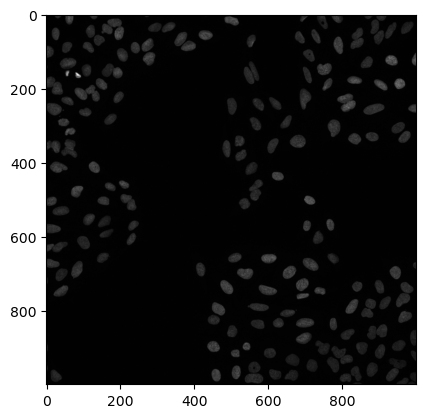

In [43]:
# import os
# import requests
# from io import BytesIO
# from matplotlib import pyplot as plt
# from matplotlib import image as mpimg
# import boto3
# from botocore import UNSIGNED
# from botocore.config import Config
# i = 0
# u = 50 #len(linked)
# test_images = []
# test_targets = []
# train_images = []
# train_targets = []
# all_targets = []
# all_images = []
# for _, row in linked.iterrows():
#     image_url = os.path.join(
#         row.PathName_OrigDNA, row.FileName_OrigDNA
#     )
#     s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
#     response = s3_client.get_object(
#         Bucket=image_url.split("/")[2], Key="/".join(image_url.split("/")[3:])
#     )
#     image = mpimg.imread(BytesIO(response["Body"].read()), format="tiff")
#     target = row.Metadata_InChIKey

#     plt.imshow(image, cmap = "gray") # , cmap="gray"
#     image_url
#     print(len(image), len(image[0]))
#     all_targets.append(target)
# #     print(os.stat(image_url).st_size)
#     all_images.append(image)
#     if i < u/2:
#         train_images.append(image)
#         train_targets.append(target)
#     else:
#         test_images.append(image)
#         test_targets.append(target)
        
#     i+=1
#     print("image " + str(i) + " of " + str(u) + " complete")
#     if i == u:
#         break
    

[[ 954  567  464 ...  435  437  427]
 [ 733  495  464 ...  436  443  414]
 [ 555  443  432 ...  427  435  412]
 ...
 [ 427  441  419 ... 1152  991  644]
 [ 434  439  423 ... 1133  968 1019]
 [ 429  439  441 ... 1105 1059 1132]]


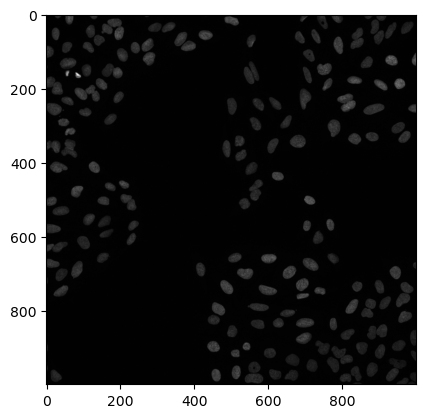

In [44]:
print(all_images[-1])
plt.imshow(all_images[-1], cmap="gray")

In [77]:
suffix= "images/2020_11_04_CPJUMP1/images/BR00117010__2020-11-08T18_18_00-Measurement1/Images/r01c01f01p01-ch1sk1fk1fl1.tiff"


In [88]:
! aws s3 cp \--no-sign-request \s3://cellpainting-gallery/cpg0000-jump-pilot/source_4/{suffix} image_temp

download: s3://cellpainting-gallery/cpg0000-jump-pilot/source_4/images/2020_11_04_CPJUMP1/images/BR00117010__2020-11-08T18_18_00-Measurement1/Images/r01c01f01p01-ch1sk1fk1fl1.tiff to image_temp/r01c01f01p01-ch1sk1fk1fl1.tiff


In [91]:
! aws s3 sync \--no-sign-request \s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/ image_temp

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c02f01p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c02f01p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Assaylayout/p_DMSO.xml to image_temp/Assaylayout/p_DMSO.xml
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/FFC_Profile/FFC_Profile_Measurement 1.xml to image_temp/FFC_Profile/FFC_Profile_Measurement 1.xml
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c02f01p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c02f01p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c03f03p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c03f03p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c03f03p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c03f03p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c03f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c03f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c03f03p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c03f03p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c05f01p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c05f01p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c05f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c05f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c05f02p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c05f02p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c05f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c05f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c06f03p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c06f03p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c06f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c06f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c06f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c06f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c06f04p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c06f04p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c08f01p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c08f01p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c08f02p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c08f02p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c08f01p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c08f01p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c08f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c08f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c09f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c09f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c09f03p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c09f03p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c09f04p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c09f04p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c09f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c09f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c11f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c11f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c11f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c11f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c11f02p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c11f02p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c11f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c11f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c12f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c12f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c11f04p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c11f04p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c11f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c11f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c13f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c13f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c14f03p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c14f03p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c14f03p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c14f03p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c14f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c14f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c14f03p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c14f03p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c15f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c15f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c15f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c15f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c16f02p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c16f02p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c16f01p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c16f01p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c17f04p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c17f04p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c17f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c17f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c17f04p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c17f04p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c17f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c17f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c19f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c19f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c19f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c19f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c19f02p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c19f02p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c19f01p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c19f01p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c20f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c20f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c20f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c20f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c20f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c20f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c20f04p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c20f04p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c22f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c22f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c22f02p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c22f02p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c22f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c22f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c21f03p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c21f03p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c23f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c23f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c23f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c23f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c23f04p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c23f04p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c23f04p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c23f04p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c25f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c25f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c25f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c25f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c25f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c25f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c25f03p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c25f03p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c26f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c26f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c26f04p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c26f04p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c27f01p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c27f01p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c26f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c26f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c28f03p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c28f03p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c28f03p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c28f03p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c28f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c28f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c28f01p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c28f01p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c30f01p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c30f01p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c30f01p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c30f01p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c30f02p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c30f02p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c30f02p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c30f02p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c31f03p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c31f03p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c31f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c31f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c31f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c31f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c31f03p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c31f03p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c33f01p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c33f01p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c33f02p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c33f02p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c33f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c33f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c33f02p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c33f02p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c34f04p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c34f04p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c34f02p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c34f02p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c34f04p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c34f04p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c34f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c34f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c36f02p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c36f02p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c36f02p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c36f02p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c36f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c36f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c36f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c36f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c37f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c37f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c37f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c37f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c38f01p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c38f01p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c37f03p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c37f03p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c39f02p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c39f02p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c39f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c39f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c39f03p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c39f03p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c39f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c39f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c41f01p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c41f01p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c41f01p01-ch3sk1fk1fl1.tiff to image_temp/Images/r01c41f01p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c41f01p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c41f01p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c41f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c41f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c42f03p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c42f03p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c42f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c42f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c42f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c42f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c42f04p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c42f04p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c44f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c44f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c43f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c43f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c43f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c43f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c44f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c44f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c45f03p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c45f03p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c45f04p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c45f04p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c45f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c45f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c45f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r01c45f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c47f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r01c47f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c47f01p01-ch6sk1fk1fl1.tiff to image_temp/Images/r01c47f01p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c47f02p01-ch1sk1fk1fl1.tiff to image_temp/Images/r01c47f02p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r01c47f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r01c47f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c02f02p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c02f02p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c02f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c02f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c02f03p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c02f03p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c02f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c02f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c04f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c04f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c03f04p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c03f04p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c04f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c04f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c04f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c04f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c05f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c05f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c05f04p01-ch6sk1fk1fl1.tiff to image_temp/Images/r02c05f04p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c05f04p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c05f04p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c06f01p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c06f01p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c07f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c07f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c07f02p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c07f02p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c07f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c07f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c07f03p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c07f03p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c09f01p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c09f01p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c08f03p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c08f03p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c09f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c09f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c09f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c09f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c10f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c10f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c10f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c10f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c10f04p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c10f04p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c10f04p01-ch6sk1fk1fl1.tiff to image_temp/Images/r02c10f04p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c12f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c12f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c12f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c12f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c12f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c12f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c12f02p01-ch6sk1fk1fl1.tiff to image_temp/Images/r02c12f02p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c13f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c13f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c13f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c13f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c13f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c13f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c13f04p01-ch6sk1fk1fl1.tiff to image_temp/Images/r02c13f04p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c15f02p01-ch6sk1fk1fl1.tiff to image_temp/Images/r02c15f02p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c15f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c15f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c15f03p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c15f03p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c15f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c15f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c16f04p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c16f04p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c16f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c16f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c17f01p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c17f01p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c17f01p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c17f01p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c18f03p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c18f03p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c18f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c18f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c18f03p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c18f03p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c18f03p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c18f03p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c20f01p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c20f01p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c20f01p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c20f01p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c20f01p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c20f01p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c20f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c20f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c21f03p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c21f03p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c21f03p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c21f03p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c21f03p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c21f03p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c21f03p01-ch6sk1fk1fl1.tiff to image_temp/Images/r02c21f03p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c23f01p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c23f01p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c23f01p01-ch6sk1fk1fl1.tiff to image_temp/Images/r02c23f01p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c23f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c23f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c23f02p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c23f02p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c24f04p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c24f04p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c24f04p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c24f04p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c24f04p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c24f04p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c24f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c24f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c26f02p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c26f02p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c26f02p01-ch2sk1fk1fl1.tiff to image_temp/Images/r02c26f02p01-ch2sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c26f02p01-ch3sk1fk1fl1.tiff to image_temp/Images/r02c26f02p01-ch3sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c26f02p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c26f02p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c27f04p01-ch4sk1fk1fl1.tiff to image_temp/Images/r02c27f04p01-ch4sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c27f04p01-ch5sk1fk1fl1.tiff to image_temp/Images/r02c27f04p01-ch5sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c27f04p01-ch6sk1fk1fl1.tiff to image_temp/Images/r02c27f04p01-ch6sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_06-Measurement1/Images/r02c28f01p01-ch1sk1fk1fl1.tiff to image_temp/Images/r02c28f01p01-ch1sk1fk1fl1.tiff
download: s3://cellpainting-gallery/cpg0016-jump/source_1/images/Batch1_20221004/images/UL000109__2022-10-05T06_35_0

import pipeline (or make own)

In [45]:
# Load pipeline and inspect modules
pipeline = cpp.Pipeline()
pipeline.load("./JUMP_segment_LoadData_v1.cppipe")

# Remove first 4 modules: Images, Metadata, NamesAndTypes, Groups...
# (replaced by InjectImage module below)

# for i in range(2):
#     print('Remove module: ', pipeline.modules()[0].module_name)
#     pipeline.remove_module(1)

print('Pipeline modules:')
for module in pipeline.modules():
    print(module.module_num, module.module_name)

Pipeline modules:
1 LoadData
2 FlagImage
3 CorrectIlluminationApply
7 CorrectIlluminationCalculate
8 CorrectIlluminationApply
9 IdentifyPrimaryObjects
10 IdentifySecondaryObjects
11 IdentifyTertiaryObjects
12 RescaleIntensity
13 RescaleIntensity
14 GrayToColor
15 ImageMath
17 OverlayOutlines
18 SaveImages
19 ExportToSpreadsheet


run pipeline on images

In [46]:
#warnings.filterwarnings('ignore')

Nuclei = pd.DataFrame()
files = list()



#for loop over all images
for image in all_images:

    pipeline_copy = pipeline.copy()
#     print(image)
#     plt.imshow(image, cmap="gray")
    
    #image = x
    # pixels =
    size_c = 1
    
    
#     # Inject image for each Channel (pipeline only handles 2 channels)
#     for c in range(0, size_c):

#         plane = pixels.getPlane(0, c, 0)
#         image_name = image.getName()

#         # Name of the channel expected in the pipeline
#         if c == 0:
#             image_name = 'OrigBlue'
#         if c == 1:
#             image_name = 'OrigGreen'

#         inject_image_module = InjectImage(image_name, plane)
#         inject_image_module.set_module_num(1)
#         pipeline_copy.add_module(inject_image_module)

    m = pipeline_copy.run()
    
#     # Results obtained as CSV from Cell Profiler
#     path = new_output_directory + '/Nuclei.csv'
#     f = pandas.read_csv(path, index_col=None, header=0)
#     f['Image'] = image.getId()
#     f['Well'] = well.getId()
#     f['Cell_Count'] = len(f.index)
#     files.append(f)

# Nuclei = pd.concat(files, ignore_index=True)

ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(workspace)
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 729, in prepare_run
    fd = self.open_csv()
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 627, in open_csv
    return open(self.csv_path, "rt")
FileNotFoundError: [Errno 2] No such file or directory: '/Users/abestroka/load_data_with_illum_local.csv'
ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(work

ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(workspace)
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 729, in prepare_run
    fd = self.open_csv()
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 627, in open_csv
    return open(self.csv_path, "rt")
FileNotFoundError: [Errno 2] No such file or directory: '/Users/abestroka/load_data_with_illum_local.csv'
ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(work

ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(workspace)
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 729, in prepare_run
    fd = self.open_csv()
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 627, in open_csv
    return open(self.csv_path, "rt")
FileNotFoundError: [Errno 2] No such file or directory: '/Users/abestroka/load_data_with_illum_local.csv'
ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(work

ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(workspace)
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 729, in prepare_run
    fd = self.open_csv()
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 627, in open_csv
    return open(self.csv_path, "rt")
FileNotFoundError: [Errno 2] No such file or directory: '/Users/abestroka/load_data_with_illum_local.csv'
ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(work

ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(workspace)
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 729, in prepare_run
    fd = self.open_csv()
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/modules/loaddata.py", line 627, in open_csv
    return open(self.csv_path, "rt")
FileNotFoundError: [Errno 2] No such file or directory: '/Users/abestroka/load_data_with_illum_local.csv'
ERROR:root:Failed to prepare run for module LoadData
Traceback (most recent call last):
  File "/Users/abestroka/anaconda3/envs/cellprofiler/lib/python3.8/site-packages/cellprofiler_core/pipeline/_pipeline.py", line 1368, in prepare_run
    not module.prepare_run(work

MODEL